In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
from leaderboard_utils import GAME_ORDER


# Load the rank data
with open('rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Get combined leaderboard with all games
selected_games = {game: True for game in GAME_ORDER}
df = get_combined_leaderboard(rank_data, selected_games)

def create_group_bar_chart(df):
    """
    Create an interactive grouped bar chart comparing AI model performance across different games
    
    Args:
        df (pd.DataFrame): DataFrame containing the combined leaderboard data
        
    Returns:
        plotly.graph_objects.Figure: The generated interactive group bar chart figure
    """
    # Get active games (those that have score columns in the DataFrame)
    active_games = []
    for game in GAME_ORDER:
        score_col = f"{game} Score"
        if score_col in df.columns:
            active_games.append(game)
    
    if not active_games:
        return None  # Return None if no games are selected

    # Prepare data for plotting
    plot_data = []
    
    for game in active_games:
        score_col = f"{game} Score"
        for _, row in df.iterrows():
            model = row['Player']
            score = row[score_col]
            
            if score != '_' and float(score) > 0:  # Only include non-zero scores
                plot_data.append({
                    'Game': game,
                    'Model': model,
                    'Score': float(score)
                })
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame(plot_data)
    
    # Calculate normalized scores for each game
    normalized_scores = []
    for game in active_games:
        game_scores = plot_df[plot_df['Game'] == game]['Score']
        mean = game_scores.mean()
        std = game_scores.std()
        
        # Normalize scores using z-score and scale to 0-100 range
        if std == 0:
            normalized = [50 if s > 0 else 0 for s in game_scores]
        else:
            z_scores = [(s - mean) / std for s in game_scores]
            normalized = [max(0, min(100, (z * 30) + 50)) for z in z_scores]
        
        normalized_scores.extend(normalized)
    
    plot_df['Normalized Score'] = normalized_scores
    
    # Create the interactive bar chart
    fig = px.bar(plot_df,
                 x='Game',
                 y='Normalized Score',
                 color='Model',
                 title='AI Model Performance Across Games',
                 labels={
                     'Normalized Score': 'Normalized Performance Score',
                     'Game': 'Game',
                     'Model': 'AI Models'
                 },
                 template='plotly_white',
                 barmode='group',
                 height=600)
    
    # Customize the layout
    fig.update_layout(
        title_x=0.5,
        title_font_size=20,
        xaxis_title_font_size=14,
        yaxis_title_font_size=14,
        legend_title_font_size=14,
        legend_font_size=12,
        xaxis_tickangle=45,
        margin=dict(l=50, r=50, t=80, b=50),
        hovermode='x unified'
    )
    
    # Add hover template
    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>' +
                     'Model: %{fullData.name}<br>' +
                     'Normalized Score: %{y:.1f}<br>' +
                     'Raw Score: %{customdata[0]:.1f}<extra></extra>',
        customdata=plot_df[['Score']].values
    )
    
    return fig

fig = create_group_bar_chart(df)
fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import json
import numpy as np
from leaderboard_utils import (
    get_sokoban_leaderboard,
    get_candy_leaderboard,
    get_ace_attorney_leaderboard,
    get_2048_leaderboard
)

# Load rank data
with open('rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Load model colors
with open('assets/model_color.json', 'r') as f:
    MODEL_COLORS = json.load(f)

def normalize_values(values, mean, std):
    """
    Normalize values using z-score and scale to 0-100 range
    """
    if std == 0:
        return [50 if v > 0 else 0 for v in values]  # Handle zero std case
    z_scores = [(v - mean) / std for v in values]
    # Scale z-scores to 0-100 range, with mean at 50
    scaled_values = [max(0, min(100, (z * 30) + 35)) for z in z_scores]
    return scaled_values

def create_comparison_bar_chart():
    # Models to compare
    models = ['o3', 'o4-mini', 'gemini-2.5-flash-preview-04-17']
    games = ['Sokoban', 'Candy Crush', 'Ace Attorney', '2048']
    
    # Get data for each game
    game_data = {
        'Sokoban': get_sokoban_leaderboard(rank_data),
        'Candy Crush': get_candy_leaderboard(rank_data),
        'Ace Attorney': get_ace_attorney_leaderboard(rank_data),
        '2048': get_2048_leaderboard(rank_data)
    }
    
    # Extract and normalize scores for each game
    normalized_scores = {model: [] for model in models}
    raw_scores = {model: [] for model in models}
    
    for game in games:
        df = game_data[game]
        game_scores = []
        
        # First collect all scores for the game to calculate mean and std
        for model in df['Player'].unique():
            if game == 'Sokoban':
                levels_str = df[df['Player'] == model]['Levels Cracked'].iloc[0]
                try:
                    levels = [int(x.strip()) for x in levels_str.split(";") if x.strip()]
                    score = max(levels) if levels else 0
                except:
                    score = 0
            else:
                score_col = 'Average Score' if game == 'Candy Crush' else 'Score'
                score = df[df['Player'] == model][score_col].iloc[0]
            game_scores.append(score)
        
        # Calculate mean and std for normalization
        mean = np.mean(game_scores)
        std = np.std(game_scores)
        
        # Get and normalize scores for our selected models
        for model in models:
            if game == 'Sokoban':
                if model in df['Player'].values:
                    levels_str = df[df['Player'] == model]['Levels Cracked'].iloc[0]
                    try:
                        levels = [int(x.strip()) for x in levels_str.split(";") if x.strip()]
                        raw_score = max(levels) if levels else 0
                    except:
                        raw_score = 0
                else:
                    raw_score = 0
            else:
                score_col = 'Average Score' if game == 'Candy Crush' else 'Score'
                raw_score = df[df['Player'] == model][score_col].iloc[0] if model in df['Player'].values else 0
            
            # Store raw score
            raw_scores[model].append(raw_score)
            
            # Normalize score
            norm_score = normalize_values([raw_score], mean, std)[0]
            normalized_scores[model].append(norm_score)
    
    # Create the grouped bar chart
    fig = go.Figure()
    
    bar_width = 0.25  # Width of each bar
    positions = list(range(len(games)))
    
    for i, (model, model_scores) in enumerate(normalized_scores.items()):
        # Get model color from MODEL_COLORS, default to gray if not found
        color = MODEL_COLORS.get(model, '#808080')
        
        # Create bar trace for each model
        fig.add_trace(go.Bar(
            name=model.lower(),  # Convert to lowercase for consistency
            x=[pos + (i - 1) * bar_width for pos in positions],  # Adjust x position for grouping
            y=model_scores,
            width=bar_width,
            marker_color=color,
            text=[f"{score:.1f}" for score in model_scores],  # Show normalized scores
            textposition='auto',
            hovertemplate="<b>%{x}</b><br>" +
                         "Model: " + model.lower() + "<br>" +
                         "Normalized Score: %{y:.1f}<br>" +
                         "Raw Score: " + "<br>".join([f"{s:.1f}" if g == 'Candy Crush' else f"{int(s)}" 
                                                    for g, s in zip(games, raw_scores[model])]) +
                         "<extra></extra>"
        ))
    
    # Update layout
    fig.update_layout(
        title="Normalized Model Performance Comparison Across Games",
        xaxis=dict(
            ticktext=games,
            tickvals=positions,
            title="Games"
        ),
        yaxis=dict(
            title="Normalized Score (0-100)",
            gridcolor='lightgray',
            range=[0, 100]  # Set fixed range for normalized scores
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        ),
        width=1000,
        height=600,
        template="plotly_white",
        showlegend=True,
        legend_title="Models"
    )
    
    return fig

if __name__ == "__main__":
    # Generate and show the chart
    fig = create_comparison_bar_chart()
    fig.show() 

In [ ]:
import json
import pandas as pd
from data_visualization import (
    get_combined_leaderboard,
    create_single_radar_chart,
    GAME_ORDER
)

# Load the rank data
with open('./rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Select only the four specific games
selected_games = {
    '2048': True,
    'Sokoban': True,
    'Candy Crush': True,
    'Ace Attorney': True
}

# Get combined leaderboard
df = get_combined_leaderboard(rank_data, selected_games)

# Create radar chart with grok-3-mini-beta highlighted
fig = create_single_radar_chart(
    df,
    selected_games=selected_games,
    highlight_models=['grok-3-mini-beta']
)

# Show the figure
fig.show()

# Optionally save the figure
# fig.write_image("grok_radar_chart.png")

In [ ]:
import json
import pandas as pd
from data_visualization import (
    get_combined_leaderboard,
    create_single_radar_chart,
    GAME_ORDER
)

# Load the rank data
with open('./rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Select only the four specific games
selected_games = {
    '2048': True,
    'Sokoban': True,
    'Candy Crush': True,
    'Ace Attorney': True
}

# Get combined leaderboard
df = get_combined_leaderboard(rank_data, selected_games)

# Create radar chart with grok-3-mini-beta highlighted
fig = create_single_radar_chart(
    df,
    selected_games=selected_games,
    highlight_models=['grok-3-mini-beta']
)

# Show the figure
fig.show()

# Optionally save the figure
# fig.write_image("grok_radar_chart.png")

In [9]:
import json
import pandas as pd
from data_visualization import (
    get_combined_leaderboard,
    create_single_radar_chart,
    GAME_ORDER
)

# Load the rank data
with open('./rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Select only the four specific games
selected_games = {
    '2048': True,
    'Sokoban': True,
    'Candy Crush': True,
    'Ace Attorney': True
}

# Get combined leaderboard
df = get_combined_leaderboard(rank_data, selected_games)

# Create radar chart with grok-3-mini-beta highlighted
fig = create_single_radar_chart(
    df,
    selected_games=selected_games,
    highlight_models=['grok-3-mini-beta']
)

# Show the figure
fig.show()

# Optionally save the figure
# fig.write_image("grok_radar_chart.png")

c:\Users\yuxua\OneDrive - UC San Diego\Desktop\academic_career\haoai_lab\LocalGenie\apps\data_visualization.py:337: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vals = df[col].replace("n/a", 0).infer_objects(copy=False).astype(float)
c:\Users\yuxua\OneDrive - UC San Diego\Desktop\academic_career\haoai_lab\LocalGenie\apps\data_visualization.py:337: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vals = df[col].replace("n/a", 0).infer_objects(copy=False).astype(float)
c:\Users\yuxua\OneDrive - UC San Diego\Desktop\academic_career\hao

Debug: Raw data for specific models

Game: 2048
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 256.0
Model: grok-3-mini-beta, Raw Score: 256.0
Model: o1-2024-12-17, Raw Score: 256.0
Model: gemini-2.5-flash-preview-04-17, Raw Score: 128.0
Model: gemini-2.5-pro-exp-03-25, Raw Score: 128.0

Game: Sokoban
Model: grok-3-mini-beta, Raw Score: 3
Model: gemini-2.5-pro-exp-03-25, Raw Score: 3
Model: gemini-2.5-flash-preview-04-17, Raw Score: 2
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 2
Model: o1-2024-12-17, Raw Score: 1

Game: Candy Crush
Model: grok-3-mini-beta, Raw Score: 106.0
Model: o1-2024-12-17, Raw Score: 97.67
Model: gemini-2.5-flash-preview-04-17, Raw Score: 59.0
Model: gemini-2.5-pro-exp-03-25, Raw Score: 51.33
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 35.33

Game: Ace Attorney
Model: o1-2024-12-17, Raw Score: 26.0
Model: gemini-2.5-pro-exp-03-25, Raw Score: 20.0
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 8.0
Model: grok-3-mini-beta, 

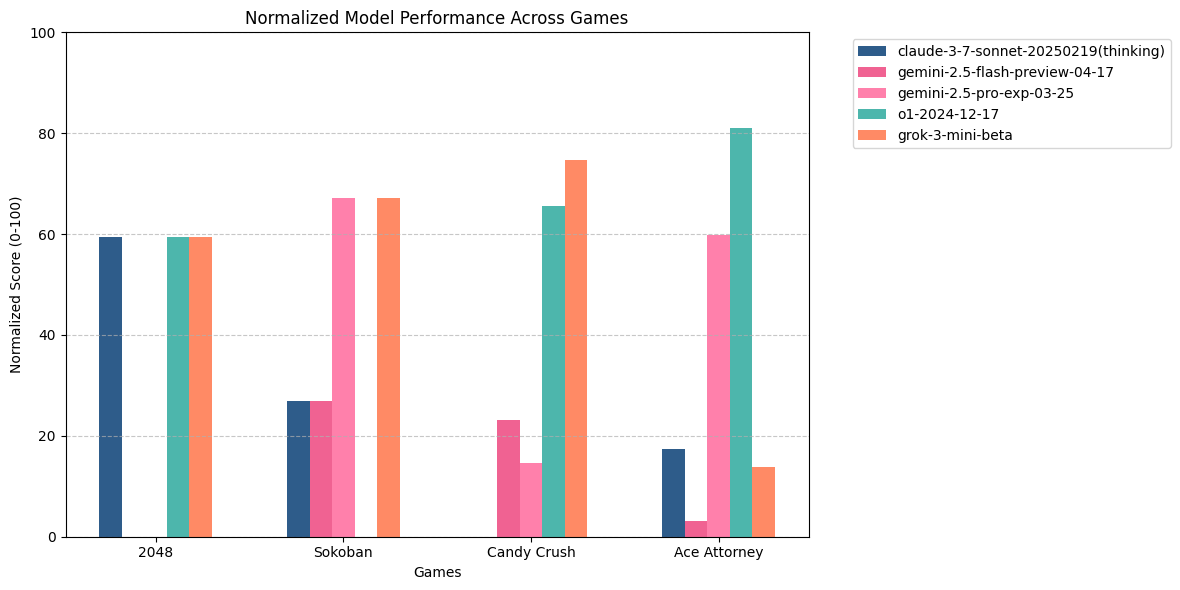

In [17]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load model colors
with open('./assets/model_color.json', 'r') as f:
    MODEL_COLORS = json.load(f)

# Load rank data
with open('./rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Define games
games = ['2048', 'Sokoban', 'Candy Crush', 'Ace Attorney']

# Selected models
selected_models = [
    'claude-3-7-sonnet-20250219(thinking)',
    'gemini-2.5-flash-preview-04-17',
    'gemini-2.5-pro-exp-03-25',
    'o1-2024-12-17',
    'grok-3-mini-beta'
]

# Debug: Print raw data for specific models
print("Debug: Raw data for specific models")
for game in games:
    print(f"\nGame: {game}")
    game_data = rank_data.get(game, {}).get('results', [])
    for item in game_data:
        if item['model'] in selected_models:
            if game == 'Candy Crush':
                score = float(item.get('average_score', 0))
            elif game == 'Sokoban':
                levels = item.get('levels_cracked', '0').split(';')
                score = max([int(level.strip()) for level in levels if level.strip()])
            elif game == 'Ace Attorney':
                score = float(item.get('score', 0))
            else:  # 2048
                score = float(item.get('score', 0))
            print(f"Model: {item['model']}, Raw Score: {score}")

def normalize_values(values, mean, std):
    """
    Normalize values using z-score and scale to 0-100 range
    """
    if std == 0:
        return [50 if v > 0 else 0 for v in values]  # Handle zero std case
    z_scores = [(v - mean) / std for v in values]
    # Scale z-scores to 0-100 range, with mean at 50
    scaled_values = [max(0, min(100, (z * 30) + 35)) for z in z_scores]
    return scaled_values

# First collect all scores for normalization
all_scores = {game: [] for game in games}
for game in games:
    game_data = rank_data.get(game, {}).get('results', [])
    for item in game_data:
        if item['model'] in selected_models:
            if game == 'Candy Crush':
                score = float(item.get('average_score', 0))
            elif game == 'Sokoban':
                levels = item.get('levels_cracked', '0').split(';')
                score = max([int(level.strip()) for level in levels if level.strip()])
            elif game == 'Ace Attorney':
                score = float(item.get('score', 0))
            else:  # 2048
                score = float(item.get('score', 0))
            all_scores[game].append(score)

# Debug: Print normalization stats
print("\nDebug: Normalization stats")
for game in games:
    scores = all_scores[game]
    if scores:
        mean = np.mean(scores)
        std = np.std(scores) if len(scores) > 1 else 1
        print(f"\nGame: {game}")
        print(f"Mean: {mean:.2f}")
        print(f"Std: {std:.2f}")
        print(f"All scores: {scores}")

# Calculate mean and std for each game
game_stats = {}
for game in games:
    scores = all_scores[game]
    if scores:
        game_stats[game] = {
            'mean': np.mean(scores),
            'std': np.std(scores) if len(scores) > 1 else 1
        }
    else:
        game_stats[game] = {'mean': 0, 'std': 1}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Set width of bars
barWidth = 0.12

# Set positions of the bars on X axis
r = np.arange(len(games))
positions = [r + i*barWidth for i in range(len(selected_models))]

# Extract and normalize data for each model
for idx, model in enumerate(selected_models):
    scores = []
    for game in games:
        game_data = rank_data.get(game, {}).get('results', [])
        model_result = next((item for item in game_data if item['model'] == model), None)
        
        if model_result:
            if game == 'Candy Crush':
                raw_score = float(model_result.get('average_score', 0))
            elif game == 'Sokoban':
                levels = model_result.get('levels_cracked', '0').split(';')
                raw_score = max([int(level.strip()) for level in levels if level.strip()])
            elif game == 'Ace Attorney':
                raw_score = float(model_result.get('score', 0))
            else:  # 2048
                raw_score = float(model_result.get('score', 0))
            # Normalize the score
            normalized_score = normalize_values(
                [raw_score], 
                game_stats[game]['mean'], 
                game_stats[game]['std']
            )[0]
            print(f"Model: {model}, Game: {game}, Raw: {raw_score}, Normalized: {normalized_score:.2f}")
        else:
            normalized_score = 0
            print(f"Model: {model}, Game: {game}, No data found")
        scores.append(normalized_score)
    
    # Create bars
    ax.bar(positions[idx], scores, width=barWidth, 
           color=MODEL_COLORS.get(model, '#808080'),
           label=model)

# Add labels and title
ax.set_xlabel('Games')
ax.set_ylabel('Normalized Score (0-100)')
ax.set_title('Normalized Model Performance Across Games')
ax.set_xticks(r + barWidth * (len(selected_models)-1)/2)
ax.set_xticklabels(games)
ax.set_ylim(0, 100)

# Add grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

Debug: Raw data for specific models

Game: 2048
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 256.0
Model: grok-3-mini-beta, Raw Score: 256.0
Model: o1-2024-12-17, Raw Score: 256.0
Model: gemini-2.5-flash-preview-04-17, Raw Score: 128.0
Model: gemini-2.5-pro-exp-03-25, Raw Score: 128.0

Game: Sokoban
Model: grok-3-mini-beta, Raw Score: 3
Model: gemini-2.5-pro-exp-03-25, Raw Score: 3
Model: gemini-2.5-flash-preview-04-17, Raw Score: 2
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 2
Model: o1-2024-12-17, Raw Score: 1

Game: Candy Crush
Model: grok-3-mini-beta, Raw Score: 106.0
Model: o1-2024-12-17, Raw Score: 97.67
Model: gemini-2.5-flash-preview-04-17, Raw Score: 59.0
Model: gemini-2.5-pro-exp-03-25, Raw Score: 51.33
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 35.33

Game: Ace Attorney
Model: o1-2024-12-17, Raw Score: 26.0
Model: gemini-2.5-pro-exp-03-25, Raw Score: 20.0
Model: claude-3-7-sonnet-20250219(thinking), Raw Score: 8.0
Model: grok-3-mini-beta, 

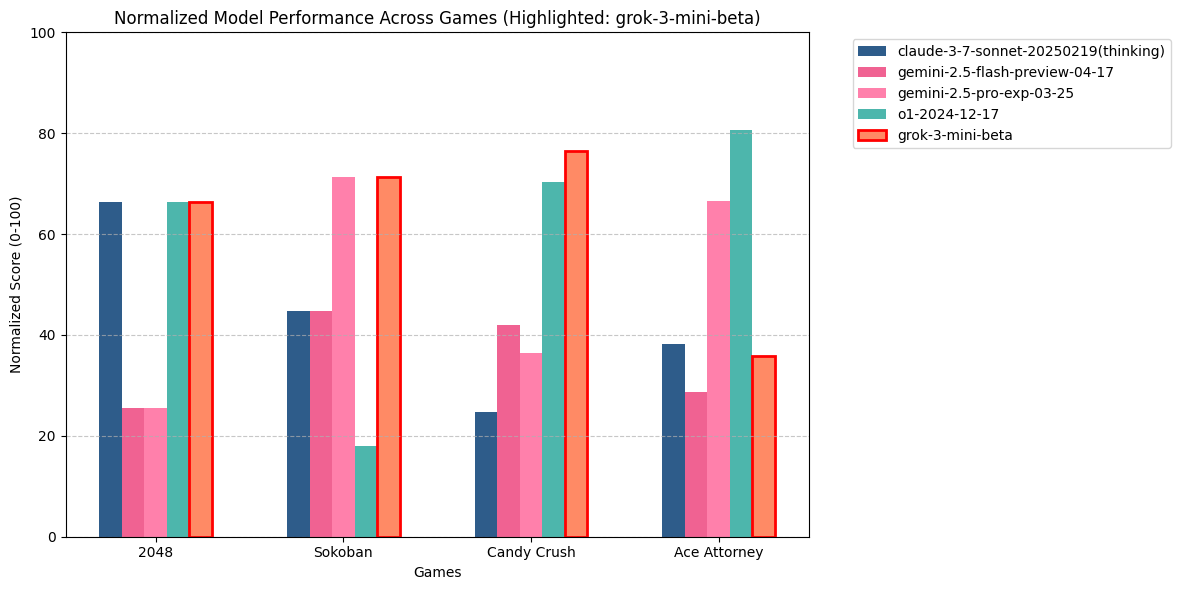

In [8]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load model colors
with open('./assets/model_color.json', 'r') as f:
    MODEL_COLORS = json.load(f)

# Load rank data
with open('./rank_data_03_25_2025.json', 'r') as f:
    rank_data = json.load(f)

# Define games
games = ['2048', 'Sokoban', 'Candy Crush', 'Ace Attorney']

# Selected models
selected_models = [
    'claude-3-7-sonnet-20250219(thinking)',
    'gemini-2.5-flash-preview-04-17',
    'gemini-2.5-pro-exp-03-25',
    'o1-2024-12-17',
    'grok-3-mini-beta'
]

# Debug: Print raw data for specific models
print("Debug: Raw data for specific models")
for game in games:
    print(f"\nGame: {game}")
    game_data = rank_data.get(game, {}).get('results', [])
    for item in game_data:
        if item['model'] in selected_models:
            if game == 'Candy Crush':
                score = float(item.get('average_score', 0))
            elif game == 'Sokoban':
                levels = item.get('levels_cracked', '0').split(';')
                score = max([int(level.strip()) for level in levels if level.strip()])
            elif game == 'Ace Attorney':
                score = float(item.get('score', 0))
            else:  # 2048
                score = float(item.get('score', 0))
            print(f"Model: {item['model']}, Raw Score: {score}")

def normalize_values(values, mean, std):
    """
    Normalize values using z-score and scale to 0-100 range with better preservation of relative differences
    """
    if std == 0:
        return [50 if v > 0 else 0 for v in values]  # Handle zero std case
    
    # Calculate z-scores
    z_scores = [(v - mean) / std for v in values]
    
    # Scale z-scores to 0-100 range with better distribution
    # Using a more gradual scaling that preserves differences
    scaled_values = []
    for z in z_scores:
        # Map z-scores to 0-100 range with better distribution
        # z-score of -2 maps to ~10, 0 maps to 50, +2 maps to ~90
        scaled = max(0, min(100, (z * 20) + 50))
        scaled_values.append(scaled)
    
    return scaled_values

# First collect all scores for normalization
all_scores = {game: [] for game in games}
for game in games:
    game_data = rank_data.get(game, {}).get('results', [])
    for item in game_data:
        if item['model'] in selected_models:
            if game == 'Candy Crush':
                score = float(item.get('average_score', 0))
            elif game == 'Sokoban':
                levels = item.get('levels_cracked', '0').split(';')
                score = max([int(level.strip()) for level in levels if level.strip()])
            elif game == 'Ace Attorney':
                score = float(item.get('score', 0))
            else:  # 2048
                score = float(item.get('score', 0))
            all_scores[game].append(score)

# Debug: Print normalization stats
print("\nDebug: Normalization stats")
for game in games:
    scores = all_scores[game]
    if scores:
        mean = np.mean(scores)
        std = np.std(scores) if len(scores) > 1 else 1
        print(f"\nGame: {game}")
        print(f"Mean: {mean:.2f}")
        print(f"Std: {std:.2f}")
        print(f"All scores: {scores}")

# Calculate mean and std for each game
game_stats = {}
for game in games:
    scores = all_scores[game]
    if scores:
        game_stats[game] = {
            'mean': np.mean(scores),
            'std': np.std(scores) if len(scores) > 1 else 1
        }
    else:
        game_stats[game] = {'mean': 0, 'std': 1}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Set width of bars
barWidth = 0.12

# Set positions of the bars on X axis
r = np.arange(len(games))
positions = [r + i*barWidth for i in range(len(selected_models))]

# Extract and normalize data for each model
for idx, model in enumerate(selected_models):
    scores = []
    for game in games:
        game_data = rank_data.get(game, {}).get('results', [])
        model_result = next((item for item in game_data if item['model'] == model), None)
        
        if model_result:
            if game == 'Candy Crush':
                raw_score = float(model_result.get('average_score', 0))
            elif game == 'Sokoban':
                levels = model_result.get('levels_cracked', '0').split(';')
                raw_score = max([int(level.strip()) for level in levels if level.strip()])
            elif game == 'Ace Attorney':
                raw_score = float(model_result.get('score', 0))
            else:  # 2048
                raw_score = float(model_result.get('score', 0))
            # Normalize the score
            normalized_score = normalize_values(
                [raw_score], 
                game_stats[game]['mean'], 
                game_stats[game]['std']
            )[0]
            print(f"Model: {model}, Game: {game}, Raw: {raw_score}, Normalized: {normalized_score:.2f}")
        else:
            normalized_score = 0
            print(f"Model: {model}, Game: {game}, No data found")
        scores.append(normalized_score)
    
    # Create bars with red outline for grok-3-mini-beta
    if model == 'grok-3-mini-beta':
        ax.bar(positions[idx], scores, width=barWidth, 
               color=MODEL_COLORS.get(model, '#808080'),
               label=model,
               edgecolor='red',
               linewidth=2)
    else:
        ax.bar(positions[idx], scores, width=barWidth, 
               color=MODEL_COLORS.get(model, '#808080'),
               label=model)

# Add labels and title
ax.set_xlabel('Games')
ax.set_ylabel('Normalized Score (0-100)')
ax.set_title('Normalized Model Performance Across Games (Highlighted: grok-3-mini-beta)')
ax.set_xticks(r + barWidth * (len(selected_models)-1)/2)
ax.set_xticklabels(games)
ax.set_ylim(0, 100)

# Add grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()